## 도서추천 시스템 코드 정리하기

### 1. 전처리 코드

In [1]:
import pandas as pd
import numpy as np
import re 

In [2]:
data = pd.read_csv('book_transactions.csv', encoding='cp949').dropna(axis=0).query('ISBN != "-"')
data['출판일자'] = pd.to_datetime(data['출판일자'],format='%Y%m%d')
data['일자'] = pd.to_datetime(data['일자'],format='%Y%m%d')
data.head()

,회원번호,일자,책제목,카테고리,작가,ISBN,출판사,출판일자,주문시간,수량,배송지
0,292,2014-06-21,유형아작 중학수학 3-2 (2014년),중고등학습서,<김순우> 등저,9788964166178,비상교육(구 비유와상징),2011-08-01,23,1,서울특별시
1,292,2014-06-21,개념+유형 중등수학 3-2 실력향상 파워 (2014년),중고등학습서,<박미정> 등저,9788966868674,비상교육(구 비유와상징),2014-03-01,23,1,서울특별시
2,292,2014-06-21,내신특강 중학 수학 3-2 (2014년),중고등학습서,<김정우> 등저,9788937898334,미래엔(대한교과서),2013-05-30,23,1,서울특별시
3,294,2014-05-28,액셀 월드 (ACCEL WORLD) 1,만화/라이트노벨,<카와하라 레키> 저/<HIMA> 그림/<김완> 역,9788926321379,서울문화사,2009-11-10,20,1,충남
4,294,2014-05-28,신약 어떤 마술의 금서목록 2,만화/라이트노벨,<카마치 카즈마> 저/<하이무라 키요타카> 그림/<김소연> 역,9788925292564,대원씨아이(단행)(대원키즈),2012-01-15,20,1,충남


In [3]:
# 데이터 확인 
print('데이터 갯수:', len(data))
print('회원수:',data['회원번호'].nunique())
print('ISBN번호 없는 갯수: ', data['ISBN'].isnull().sum())

데이터 갯수: 242767
회원수: 26607
ISBN번호 없는 갯수:  0


In [4]:
# 제거할 카테고리 모음
data = data.query("카테고리 != '잡지'")
# 중복 제거 
data = data.drop_duplicates()
data.index = range(len(data))
print('데이터 갯수:', len(data))
print('회원수:',data['회원번호'].nunique())
print('ISBN번호 없는 갯수: ', data['ISBN'].isnull().sum())

데이터 갯수: 238581
회원수: 26528
ISBN번호 없는 갯수:  0


In [5]:
# 연도 들어간 책 제거하기. 
year = []
for i in range(len(data)):
    try: 
        re.search('201[0-9]',data['책제목'][i])[0]
        year.append(i)
    except:
        pass
# 연도가 들어간 데이터 삭제하기. 
dat = data.drop(year)
len(dat)

192465

In [6]:
# 삭제가 잘 되었나 확인 
data[data['책제목']=='EBSi 강의교재 수능개념 수학영역 고동국의 꼼꼼한 기하와 벡터 강의노트 (2014년)']

,회원번호,일자,책제목,카테고리,작가,ISBN,출판사,출판일자,주문시간,수량,배송지
5517,4273,2014-01-09,EBSi 강의교재 수능개념 수학영역 고동국의 꼼꼼한 기하와 벡터 강의노트 (2014년),중고등학습서,<고동국> 저,9788954729512,한국교육방송공사,2013-11-21,21,1,울산광역시
150475,82489,2014-01-09,EBSi 강의교재 수능개념 수학영역 고동국의 꼼꼼한 기하와 벡터 강의노트 (2014년),중고등학습서,<고동국> 저,9788954729512,한국교육방송공사,2013-11-21,17,1,서울특별시
236698,99576,2014-01-25,EBSi 강의교재 수능개념 수학영역 고동국의 꼼꼼한 기하와 벡터 강의노트 (2014년),중고등학습서,<고동국> 저,9788954729512,한국교육방송공사,2013-11-21,23,1,부산광역시


In [7]:
dat[dat['책제목'] == 'EBSi 강의교재 수능개념 수학영역 고동국의 꼼꼼한 기하와 벡터 강의노트 (2014년)']

,회원번호,일자,책제목,카테고리,작가,ISBN,출판사,출판일자,주문시간,수량,배송지


In [8]:
# 1번만 구매된 도서 제거하기. 
a = dat['책제목'].value_counts()[dat['책제목'].value_counts()>1].index
dat = dat.query("책제목 in @a")
del a 
len(dat)

161206

이 상태로 negative sampling 진행 (구매이력 데이터에는 구매정보만 있지 구매하지 않은 제품에 대한 정보는 존재하지 않기 때문)

# 모델링 작업 실시 (CNNCF)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib 
import pickle

import tensorflow as tf
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.text import *
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

import random
random.seed(42)

C:\Users\hyoun\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
# Data Columns
USER, ITEM, RATING, C = '회원번호', 'ISBN', '평점', '카테고리'

# Read data

# 사용하는 데이터는 train에 구매와 구매하지 않은 정보가 모두 담겨있는 데이터여야 함 

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# use = train.회원번호.unique()
# test = test.query("회원번호 in @use")
# del use

print(train.shape, test.shape)

(340475, 3) (72825, 3)


In [4]:
data = pd.read_csv('book_transactions.csv', encoding='cp949').dropna(axis=0).query('ISBN != "-"')

data = data[data.ISBN.apply(lambda x: x[-1] not in ['X', 'x'])]
data['ISBN'] = data['ISBN'].astype(np.int64)
data = data[['ISBN', '카테고리']]
data = data.drop_duplicates()

lst = list(data.groupby('ISBN')['카테고리'].agg({'size'}).query('size > 1').index)
data = data.query('ISBN not in @lst')

print(data.shape)

(65969, 2)


In [5]:
train = pd.merge(train, data, on = ITEM, how = 'left')
test = pd.merge(test, data, on = ITEM, how = 'left')

train = train.query('ISBN not in @lst')
test = test.query('ISBN not in @lst')

print(train.shape, test.shape)

(340024, 4) (72668, 4)


In [6]:
fin = pd.concat([train,test], axis = 0).query("평점 == 1")
fin = fin[[ITEM,C]]
fin = fin.drop_duplicates()

print(fin.shape)

(65969, 2)


In [7]:
def get_data(column) :
    
    vocab = {}
    num = 0

    for i in np.hstack([train[column], test[column]]): 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in train[column]]
    print('{} :{}'.format(column, max(encoded)))
    
    return encoded, num, vocab

In [8]:
encoded_users, num_users, vocab_users = get_data(USER)
encoded_items, num_items, vocab_items = get_data(ITEM)
encoded_categorys, num_categorys, vocab_categorys = get_data(C)

print(len(encoded_categorys), len(encoded_items), len(encoded_categorys))

회원번호 :24784
ISBN :54305
카테고리 :24
340024 340024 340024


In [9]:
df = pd.concat([train[['ISBN','카테고리']], test[['ISBN','카테고리']]])

df['ISBN'] = df['ISBN'].map(vocab_items)
df['카테고리'] = df['카테고리'].map(vocab_categorys)
df = df.drop_duplicates()

category = df['카테고리'].values

In [10]:
fin = pd.concat([train,test]).query("평점 == 1")
fin = fin[['ISBN','카테고리']]
fin = fin.drop_duplicates()
fin.ISBN.value_counts().reset_index().query("ISBN > 1")

,index,ISBN


In [11]:
# ISBN 바꾸는 용 
transform_ISBN = {}
for i,j in vocab_items.items():
    transform_ISBN[j] = i

In [12]:
top_k = 10
#active_user = np.sort(random.sample(list(test[USER].unique()), 100))
active_user = np.sort(test[USER].unique()[:100])

# Model Use Function 

In [13]:
def trans_mul(vects):
    z = tf.reshape(vects,(-1,n_factors,1))
    return z 

def concat_shape2D(vects):
    v,w,x,y = vects 
    z = tf.concat([v,w],axis=2)
    z = tf.concat([z,x],axis=2)
    z = tf.concat([z,y],axis=2)
    return z

def sum_layer(vects):
    w, x, y = vects
    z = tf.add(x,y)
    z = tf.add(z,w)
    return z 

# CNNCF

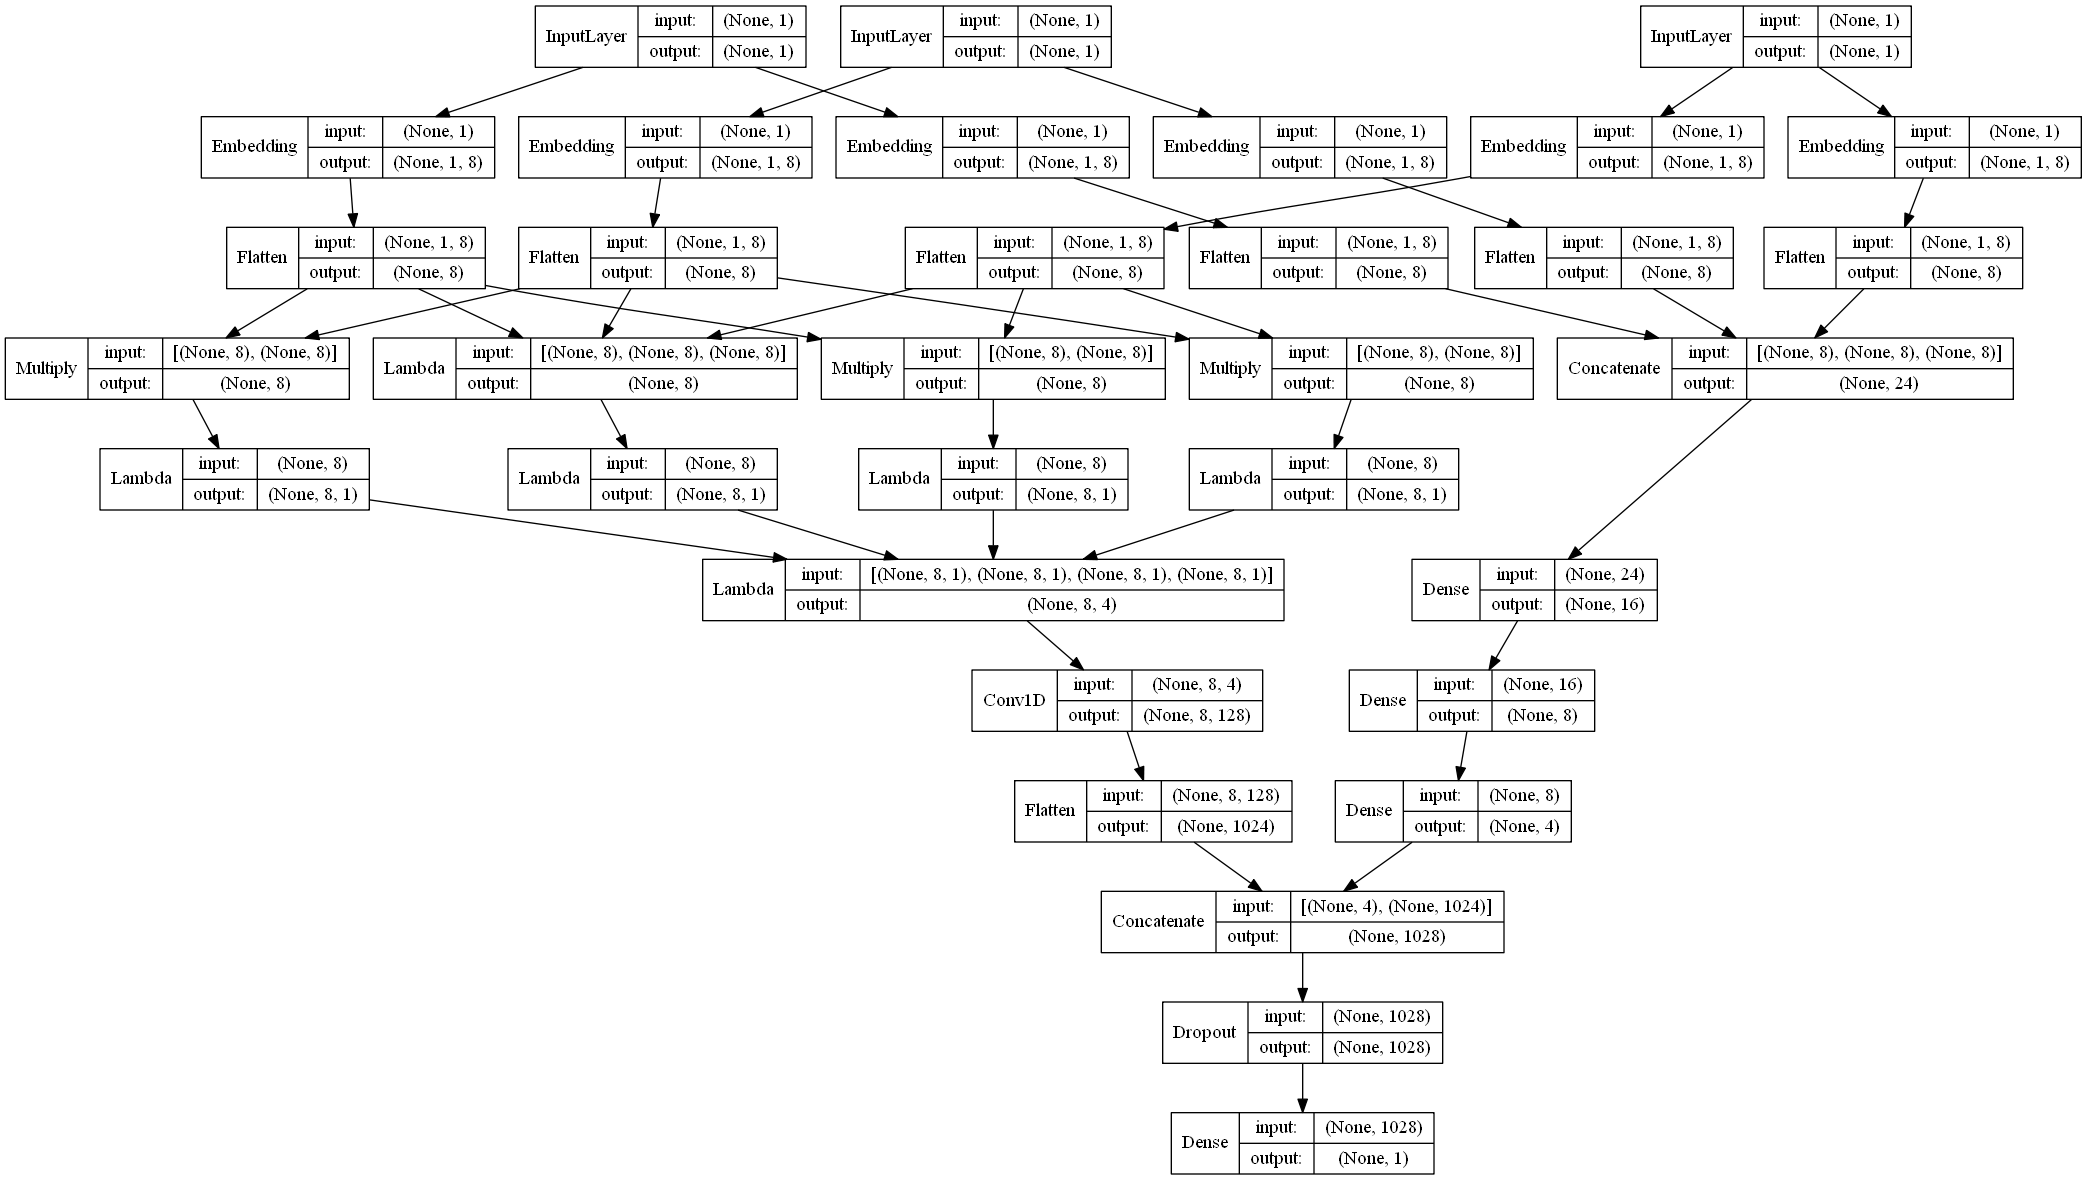

In [14]:
n_factors = 8
layers = [16, 8, 4]

# Input variables
user_input = Input(shape=(1,), dtype='int64', name = 'user_input')
item_input = Input(shape=(1,), dtype='int64', name = 'item_input')
category_input = Input(shape=(1,), dtype='int64', name = 'category_input')

# Embedding layer
FM_Embedding_User = Embedding(input_dim = num_users, output_dim = n_factors, 
                              name = 'FM_Embedding_User', input_length=1)(user_input)

FM_Embedding_Item = Embedding(input_dim = num_items, output_dim = n_factors,
                              name = 'FM_Embedding_Item', input_length=1)(item_input)   

FM_Embedding_category = Embedding(input_dim = num_categorys, output_dim = n_factors,
                              name = 'FM_Embedding_category', input_length=1)(category_input)  

MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = n_factors,
                               name = "MLP_Embedding_User", input_length=1)(user_input)

MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = n_factors,
                               name = 'MLP_Embedding_Item', input_length=1)(item_input)   

MLP_Embedding_category = Embedding(input_dim = num_categorys, output_dim = n_factors,
                                   name = 'MLP_Embedding_category', input_length=1)(category_input)  

## FM Part ##
# Flatten
fm_user_latent = Flatten()(FM_Embedding_User)
fm_item_latent = Flatten()(FM_Embedding_Item)
fm_category_latent = Flatten()(FM_Embedding_category)

# Multiply
user_item = Multiply()([fm_user_latent, fm_item_latent])
Trans_UI = Lambda(trans_mul)(user_item)

user_category = Multiply()([fm_user_latent, fm_category_latent])
Trans_UC = Lambda(trans_mul)(user_category)

item_category = Multiply()([fm_item_latent, fm_category_latent])
Trans_IC = Lambda(trans_mul)(item_category)

add_interaction = Lambda(sum_layer)([fm_user_latent, fm_item_latent, fm_category_latent])
Trans_sum = Lambda(trans_mul)(add_interaction)

MF_part = Lambda(concat_shape2D)([Trans_UI, Trans_UC, Trans_IC, Trans_sum])
MF_part = Conv1D(128,kernel_size=1,activation='elu')(MF_part)
MF_part = Flatten()(MF_part)
## MLP part ##
# Flatten
mlp_user_latent = Flatten()(MLP_Embedding_User)
mlp_item_latent = Flatten()(MLP_Embedding_Item)
mlp_category_latent = Flatten()(MLP_Embedding_category)

mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent, mlp_category_latent])

for idx in range(len(layers)):
    mlp_vector = Dense(layers[idx], activation='relu', name=f"layer{idx}")(mlp_vector)

# Concatenate FM and MLP parts
predict_vector = Concatenate()([mlp_vector,MF_part])
predict_vector = Dropout(0.3)(predict_vector)

# Final prediction layer
prediction = Dense(1, activation='sigmoid', name = "prediction")(predict_vector)

model = Model([user_input, item_input, category_input], prediction)

model.compile(loss="binary_crossentropy", optimizer=RMSprop(lr=0.0001), metrics=["accuracy"])

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

C:\Users\hyoun\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 306021 samples, validate on 34003 samples
Epoch 1/30
306021/306021 [==============================] - 27s 90us/step - loss: 0.6758 - accuracy: 0.5690 - val_loss: 0.6822 - val_accuracy: 0.5758
Epoch 2/30
306021/306021 [==============================] - 25s 83us/step - loss: 0.6445 - accuracy: 0.6171 - val_loss: 0.6478 - val_accuracy: 0.6120
Epoch 3/30
306021/306021 [==============================] - 26s 85us/step - loss: 0.5982 - accuracy: 0.6687 - val_loss: 0.6046 - val_accuracy: 0.6616
Epoch 4/30
306021/306021 [==============================] - 26s 87us/step - loss: 0.5535 - accuracy: 0.7135 - val_loss: 0.5744 - val_accuracy: 0.6969
Epoch 5/30
306021/306021 [==============================] - 27s 89us/step - loss: 0.5184 - accuracy: 0.7469 - val_loss: 0.5499 - val_accuracy: 0.7238
Epoch 6/30
306021/306021 [==============================] - 28s 91us/step - loss: 0.4897 - accuracy: 0.7723 - val_loss: 0.5314 - val_accuracy: 0.7466
Epoch 7/30
306021/306021 [=======================

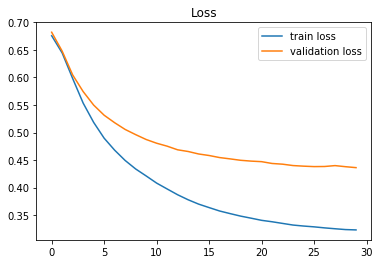

In [15]:
history = model.fit(x=[encoded_users, encoded_items, encoded_categorys], y=train[RATING], 
                    batch_size=128, epochs=30, validation_split=0.1, 
                    callbacks=[EarlyStopping(patience=3)], verbose=1)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

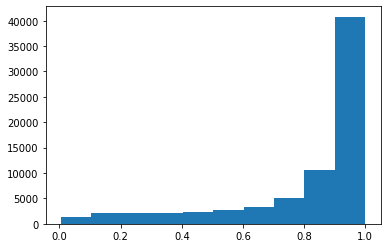

In [16]:
# 예측 rating(0~1) 빈도 도식화
plt.hist(model.predict([[vocab_users[i] for i in test[USER]], 
                        [vocab_items[i] for i in test[ITEM]],
                       [vocab_categorys[i] for i in test[C]]]))

plt.show()

In [17]:
# 정확도 측정
model.evaluate([[vocab_users[i] for i in test[USER]],
                [vocab_items[i] for i in test[ITEM]],
               [vocab_categorys[i] for i in test[C]]],
               test[RATING])[1]

72668/72668 [==============================] - 12s 159us/step


0.8634337186813354

In [18]:
# 각 사용자별 추천 리스트 데이터 프레임 형식으로 출력

recs = []
prob = []

test_uid = active_user.copy()

for i, u in enumerate(test_uid):
    if i % 10 == 0:
        print('--------------------------------------------------------------------------')
        print(i, '번째 진행중 입니다.' , len(test_uid) - i, '만큼만 기다려 주세요.')
    pred = model.predict([[vocab_users[u]]*len(vocab_items),
                          range(len(vocab_items)),
                          category]).flatten()
    
    rec = set([list(vocab_items.keys())[i] for i in np.argsort(-pred)[:top_k]])
    recs.append(rec)
    
    prob.append([i for i in np.sort(pred)[::-1][:top_k]])
    
recs = pd.DataFrame(pd.DataFrame(recs, index=test_uid).stack()).reset_index(). \
                    rename({'level_0':USER, 0: ITEM}, axis=1).iloc[:,[0,2]]

prob = pd.DataFrame(prob, index=test_uid).stack().reset_index().rename({0: 'score'}, axis=1).iloc[:,[2]]

recs_prob = pd.concat([recs, prob], axis=1)

--------------------------------------------------------------------------
0 번째 진행중 입니다. 100 만큼만 기다려 주세요.
--------------------------------------------------------------------------
10 번째 진행중 입니다. 90 만큼만 기다려 주세요.
--------------------------------------------------------------------------
20 번째 진행중 입니다. 80 만큼만 기다려 주세요.
--------------------------------------------------------------------------
30 번째 진행중 입니다. 70 만큼만 기다려 주세요.
--------------------------------------------------------------------------
40 번째 진행중 입니다. 60 만큼만 기다려 주세요.
--------------------------------------------------------------------------
50 번째 진행중 입니다. 50 만큼만 기다려 주세요.
--------------------------------------------------------------------------
60 번째 진행중 입니다. 40 만큼만 기다려 주세요.
--------------------------------------------------------------------------
70 번째 진행중 입니다. 30 만큼만 기다려 주세요.
--------------------------------------------------------------------------
80 번째 진행중 입니다. 20 만큼만 기다려 주세요.
----------------------------------------------

In [19]:
from python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

# all ranking metrics have the same arguments
args = [test, recs_prob]
kwargs = dict(col_user=USER, 
              col_item=ITEM, 
              col_rating=RATING, 
              col_prediction='score', 
              relevancy_method='top_k', 
              k=10)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

print(f"Model:",
      f"Top K:\t\t {10}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}", sep='\n')

Model:
Top K:		 10
MAP:		 0.004600
NDCG:		 0.018108
Precision@K:	 0.014000
Recall@K:	 0.011269


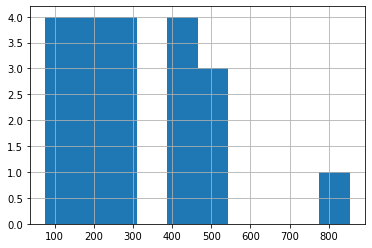

In [20]:
data = pd.read_csv("book_transactions.csv", encoding = 'cp949').dropna(axis=0).query('ISBN != "-"')
data = data[data['ISBN'].apply(lambda x: x[-1] not in ['X', 'x'])]
data['ISBN'] = data['ISBN'].astype(np.int64)

rec_list = (recs_prob['ISBN'].unique())
data_in_rec = data.query('ISBN in @rec_list')
data_in_rec['ISBN'].value_counts().hist()